In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import time 
import tqdm
import glob
import yaml
import os

from sklearn.preprocessing import StandardScaler
import multiprocessing as mp

from mlguess.pit import pit_deviation_skill_score, pit_deviation
from mlguess.keras.models import EvidentialRegressorDNN


from mlguess.keras.callbacks import get_callbacks
from mlguess.regression_uq import compute_results
#from mlguess.regression_uq import Test1AB
import tensorflow as tf
import random

2024-09-09 13:02:10.852896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 13:02:10.852926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 13:02:10.854419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 13:02:10.862575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 13:02:11.883545: W tensorflow/compiler/tf2

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [3]:
"source ~/.bashrc","module unload cuda cudnn","conda activate guess-gpu3",'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))','export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib','export XLA_FLAGS=--xla_gpu_cuda_data_dir=$CONDA_PREFIX'

('source ~/.bashrc',
 'module unload cuda cudnn',
 'conda activate guess-gpu3',
 'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))',
 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib',
 'export XLA_FLAGS=--xla_gpu_cuda_data_dir=$CONDA_PREFIX')

In [4]:
config = '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/evidential_with_echo_output/config/best_re_echo_trial_194_PR11.yml'

In [5]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [6]:
conf['model']

{'activation': 'relu',
 'batch_size': 12415,
 'dropout_alpha': 0.152712630043728,
 'epochs': 2000,
 'evidential_coef': 0.5880854988378059,
 'hidden_layers': 1,
 'hidden_neurons': 823,
 'kernel_reg': 'l2',
 'l1_weight': 5.13946696844333e-11,
 'l2_weight': 5.1109726042924564e-08,
 'loss': 'evidentialReg',
 'lr': 1.6914868229211361e-06,
 'metrics': 'mae',
 'optimizer': 'adam',
 'use_dropout': True,
 'use_noise': False,
 'verbose': 2}

In [7]:
#met_vars are 11 feature variables, output_vars is my single target variable
met_vars = conf["met_vars"]
output_vars = conf["output_vars"]
seed = conf["seed"]
print(seed)

1000


In [8]:
# this is a list
output_vars

['WG_o(m/s)']

In [9]:
met_vars

['WS_950mb(m/s)',
 'WS_850mb(m/s)',
 'WS_10m(m/s)',
 'PBLH(km)',
 'Ustar(m/s)',
 'Temp_grad(1km_sfc)(C/km)',
 'Temp_grad(2km_sfc)(C/km)',
 'Terrain_height(m)',
 'WindDC(cos)',
 'WindDC(sin)',
 'yday']

In [10]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [11]:
train_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/train_data.csv'
valid_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/valid_data.csv'

In [12]:
# Gridded test data
test_data_path= '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/Processed_test_grid/'

In [13]:
test_data1= pd.read_csv(test_data_path+'Processed_WRF422_2020040912.csv')
test_data2= pd.read_csv(test_data_path+'Processed_WRF422_2020082900.csv')
test_data3= pd.read_csv(test_data_path+'Processed_WRF422_2020093000.csv')
test_data4= pd.read_csv(test_data_path+'Processed_WRF422_2020110112.csv')
test_data5= pd.read_csv(test_data_path+'Processed_WRF422_2020120500.csv')
test_data6= pd.read_csv(test_data_path+'Processed_WRF422_2021030118.csv')  
test_data7= pd.read_csv(test_data_path+'Processed_WRF422_2021042112.csv')
test_data8= pd.read_csv(test_data_path+'Processed_WRF422_2021072918.csv')
test_data9= pd.read_csv(test_data_path+'Processed_WRF422_2021081900.csv') 
test_data10= pd.read_csv(test_data_path+'Processed_WRF422_2021090812.csv')
test_data11= pd.read_csv(test_data_path+'Processed_WRF422_2021111118.csv')

In [14]:
train_data= pd.read_csv(train_data_path)
valid_data= pd.read_csv(valid_data_path)

In [15]:
test_data= pd.concat([test_data1,test_data2,test_data3,test_data4,test_data5,test_data6,
                     test_data7,test_data8,test_data9,test_data10,test_data11],axis=0,ignore_index=True)

In [16]:
def seed_everything(seed):
    """Set seeds for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

In [17]:
x_train = scaler_x.fit_transform(train_data[met_vars])
x_valid = scaler_x.transform(valid_data[met_vars])
x_test = scaler_x.transform(test_data[met_vars])

y_train = scaler_y.fit_transform(train_data[output_vars])
y_valid = scaler_y.transform(valid_data[output_vars])
#y_test = scaler_y.transform(test_data[output_vars])

In [18]:
# Fix seed for reproducibility
seed_everything(seed)

In [19]:
#Load the model
model = EvidentialRegressorDNN(**conf["model"])
model.build_neural_network(x_train.shape[-1], y_train.shape[-1])
model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          callbacks=get_callbacks(conf))
history = model.model.history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11)]              0         
                                                                 
 dense_00 (Dense)            (None, 823)               9876      
                                                                 
 dropout_h_00 (Dropout)      (None, 823)               0         
                                                                 
 DenseNormalGamma (DenseNor  (None, 4)                 3300      
 malGamma)                                                       
                                                                 
Total params: 13176 (51.47 KB)
Trainable params: 13172 (51.45 KB)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


2024-09-09 13:03:08.323550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37064 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-09-09 13:03:08.325291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37954 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2024-09-09 13:03:08.326762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37954 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-09-09 13:03:08.328406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37954 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

Epoch 1/2000


2024-09-09 13:03:12.614329: I external/local_xla/xla/service/service.cc:168] XLA service 0x15383c1678f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-09 13:03:12.614347: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-09 13:03:12.614351: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-09 13:03:12.614354: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-09 13:03:12.614357: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-09-09 13:03:12.620324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-09 13:0

11/11 - 5s - loss: 2.9061 - mae: 0.7862 - val_loss: 3.5690 - val_mae: 1.0029 - lr: 1.6915e-06 - 5s/epoch - 446ms/step
Epoch 2/2000
11/11 - 0s - loss: 2.9024 - mae: 0.7854 - val_loss: 3.5651 - val_mae: 1.0022 - lr: 1.6915e-06 - 107ms/epoch - 10ms/step
Epoch 3/2000


/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 - 0s - loss: 2.8995 - mae: 0.7845 - val_loss: 3.5616 - val_mae: 1.0014 - lr: 1.6915e-06 - 96ms/epoch - 9ms/step
Epoch 4/2000
11/11 - 0s - loss: 2.8970 - mae: 0.7840 - val_loss: 3.5582 - val_mae: 1.0007 - lr: 1.6915e-06 - 95ms/epoch - 9ms/step
Epoch 5/2000
11/11 - 0s - loss: 2.8949 - mae: 0.7836 - val_loss: 3.5548 - val_mae: 1.0000 - lr: 1.6915e-06 - 94ms/epoch - 9ms/step
Epoch 6/2000
11/11 - 0s - loss: 2.8916 - mae: 0.7827 - val_loss: 3.5514 - val_mae: 0.9993 - lr: 1.6915e-06 - 95ms/epoch - 9ms/step
Epoch 7/2000
11/11 - 0s - loss: 2.8889 - mae: 0.7821 - val_loss: 3.5480 - val_mae: 0.9986 - lr: 1.6915e-06 - 93ms/epoch - 8ms/step
Epoch 8/2000
11/11 - 0s - loss: 2.8866 - mae: 0.7814 - val_loss: 3.5446 - val_mae: 0.9979 - lr: 1.6915e-06 - 93ms/epoch - 8ms/step
Epoch 9/2000
11/11 - 0s - loss: 2.8836 - mae: 0.7807 - val_loss: 3.5413 - val_mae: 0.9972 - lr: 1.6915e-06 - 93ms/epoch - 8ms/step
Epoch 10/2000
11/11 - 0s - loss: 2.8813 - mae: 0.7802 - val_loss: 3.5379 - val_mae: 0.9965 - lr:

In [22]:
test_data

,Unnamed: 0.1,Unnamed: 0,i-0,Lat,Lon,YYYY,MM,DD,HH,PSFC(Pa),...,Terrain_height(m),Ustar(m/s),SfcWG_UPP(m/s),Temp_grad(1km_sfc)(C/km),Temp_grad(2km_sfc)(C/km),WindDC(cos),WindDC(sin),Valid_Time_x,day_of_year,yday
0,0,0,0,39.61,-78.07,2020,4,9,12,97122.70,...,205.21,0.39,2.55,3.17,4.12,-0.990268,-0.139173,2020-04-09 12:00:00,100,-0.133015
1,1,1,0,39.61,-78.02,2020,4,9,12,97276.43,...,191.92,0.44,3.15,2.92,4.14,-0.989016,-0.147809,2020-04-09 12:00:00,100,-0.133015
2,2,2,0,39.61,-77.98,2020,4,9,12,97397.03,...,181.34,0.51,3.85,2.67,4.16,-0.983571,-0.180519,2020-04-09 12:00:00,100,-0.133015
3,3,3,0,39.61,-77.93,2020,4,9,12,97539.30,...,168.72,0.39,4.75,2.50,4.19,-0.967709,-0.252069,2020-04-09 12:00:00,100,-0.133015
4,4,4,0,39.61,-77.88,2020,4,9,12,97657.25,...,158.08,0.42,5.15,2.41,4.24,-0.951057,-0.309017,2020-04-09 12:00:00,100,-0.133015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18050555,1640955,1640955,48,45.74,-68.86,2021,11,13,18,98570.56,...,179.08,0.36,2.42,6.25,6.16,-0.780430,0.625243,2021-11-13 18:00:00,317,0.664855
18050556,1640956,1640956,48,45.73,-68.81,2021,11,13,18,98711.67,...,167.40,0.36,2.42,6.20,6.11,-0.793353,0.608761,2021-11-13 18:00:00,317,0.664855
18050557,1640957,1640957,48,45.73,-68.76,2021,11,13,18,98798.73,...,160.33,0.37,2.52,6.11,6.02,-0.837719,0.546102,2021-11-13 18:00:00,317,0.664855
18050558,1640958,1640958,48,45.72,-68.70,2021,11,13,18,98889.58,...,152.87,0.37,2.42,6.06,5.99,-0.855364,0.518027,2021-11-13 18:00:00,317,0.664855


In [25]:
def YYYYMMDDHH_string(Datetime_Value):
    if Datetime_Value.month>9:
        Month_str = str(Datetime_Value.month)
    else:
        Month_str = "0"+str(Datetime_Value.month)   
    if Datetime_Value.day>9:
        Day_str = str(Datetime_Value.day)
    else:
        Day_str = "0"+str(Datetime_Value.day)
    if Datetime_Value.hour>9:
        Hour_str = str(Datetime_Value.hour)
    else:
        Hour_str = "0"+str(Datetime_Value.hour)
    return (str(Datetime_Value.year)+Month_str+Day_str+Hour_str)

In [26]:
from datetime import datetime
from datetime import timedelta
import time

In [50]:
from scipy.interpolate import griddata
# Load CSV file with station latitude and longitude values
stations = pd.read_csv('/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/Stations_ISD_NYSM.csv')

### Following blocks of code were written to get alatoric and epistemic variances
### and to get the UQ plots

In [35]:
result_new = model.predict_uncertainty(x_test,scaler = scaler_y)

1454/1454 [==============================] - 2s 939us/step


In [36]:
mu, aleatoric_var, epistemic_var = result_new

In [58]:
# Combine mean predictions with longitude, latitude, and time
Y_pred_df_new = pd.DataFrame({'Predictions': mu.ravel(), 
                          'Ale(var)':aleatoric_var.ravel(), 
                          'Epi(var)':epistemic_var.ravel(),
                          'Lat': test_data['Lat'],
                          'Lon': test_data['Lon'], 
                          'YYYY': test_data['YYYY'],
                          'MM' : test_data['MM'],
                          'DD': test_data['DD'], 
                          'HH' : test_data['HH']})

In [59]:
Time_Valid = np.empty((len(Y_pred_df_new), 1), dtype=object)
for x in range(len(Y_pred_df_new)):
    date = datetime(Y_pred_df_new["YYYY"][x],Y_pred_df_new["MM"][x],Y_pred_df_new["DD"][x],Y_pred_df_new["HH"][x],0,0)
    Time_Valid[x,0] = YYYYMMDDHH_string(date)

In [60]:
Y_pred_df_new['Time']=pd.DataFrame(Time_Valid)

In [61]:
Y_pred_df_new['Time'] = pd.to_datetime(Y_pred_df_new['Time'], format='%Y%m%d%H')

In [62]:
Y_pred_df_new

,Predictions,Ale(var),Epi(var),Lat,Lon,YYYY,MM,DD,HH,Time
0,9.158436,0.528471,2.139953,39.61,-78.07,2020,4,9,12,2020-04-09 12:00:00
1,9.244447,0.553481,2.139217,39.61,-78.02,2020,4,9,12,2020-04-09 12:00:00
2,9.357783,0.591387,2.153482,39.61,-77.98,2020,4,9,12,2020-04-09 12:00:00
3,9.392804,0.602616,2.197010,39.61,-77.93,2020,4,9,12,2020-04-09 12:00:00
4,9.480531,0.631658,2.217455,39.61,-77.88,2020,4,9,12,2020-04-09 12:00:00
...,...,...,...,...,...,...,...,...,...,...
18050555,8.201134,0.429017,1.645672,45.74,-68.86,2021,11,13,18,2021-11-13 18:00:00
18050556,8.193658,0.428096,1.648462,45.73,-68.81,2021,11,13,18,2021-11-13 18:00:00
18050557,8.207161,0.431938,1.655760,45.73,-68.76,2021,11,13,18,2021-11-13 18:00:00
18050558,8.198196,0.429564,1.661642,45.72,-68.70,2021,11,13,18,2021-11-13 18:00:00


In [69]:
# Initialize an empty dataframe to store the results
final_interpolated_df_new = pd.DataFrame() 

In [64]:
Y_pred_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050560 entries, 0 to 18050559
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Predictions  float32       
 1   Ale(var)     float32       
 2   Epi(var)     float32       
 3   Lat          float64       
 4   Lon          float64       
 5   YYYY         int64         
 6   MM           int64         
 7   DD           int64         
 8   HH           int64         
 9   Time         datetime64[ns]
dtypes: datetime64[ns](1), float32(3), float64(2), int64(4)
memory usage: 1.1 GB


In [54]:
## interpolate gridded output(pred and variances) to station locations

In [70]:
# Iterate over unique time values in the dataframe
for day in Y_pred_df_new['Time'].unique():
    # Convert the numpy datetime64 to pandas Timestamp
    day = pd.Timestamp(day)
    
    # Filter Y_pred_df to include only data from the current hour
    day_data = Y_pred_df_new[
        (Y_pred_df_new['Time'].dt.year == day.year) & 
        (Y_pred_df_new['Time'].dt.month == day.month) & 
        (Y_pred_df_new['Time'].dt.day == day.day) & 
        (Y_pred_df_new['Time'].dt.hour == day.hour)
    ]
    # Print the length of day_data
    print(f"Time: {day}, Number of records: {len(day_data)}")
    if day_data.empty:
        continue  # If no data available for this time, skip

    # Define the points which you want to interpolate
    points = day_data[['Lat', 'Lon']].values
    
    # Define the values corresponding to the points
    pred_values = day_data['Predictions'].values
    ale_values = day_data['Ale(var)'].values
    epi_values = day_data['Epi(var)'].values
    
    # Define the grid where you want to interpolate (based on obs dataframe)
    grid_x = stations['Lat'].values
    grid_y = stations['Lon'].values
    
    # Perform the interpolation
    interpolated_pred = griddata(points, pred_values, (grid_x, grid_y), method='linear')
    interpolated_ale = griddata(points, ale_values, (grid_x, grid_y), method='linear')
    interpolated_epi = griddata(points, epi_values, (grid_x, grid_y), method='linear')
    
    # Create a new dataframe with interpolated values, latitudes, longitudes, and corresponding Station_ID
    interpolated_df = pd.DataFrame({
        'Interpolated_Predictions': interpolated_pred,
        'Interpolated_Aleatoric(var)': interpolated_ale,
        'Interpolated_Epistemic(var)': interpolated_epi,
        'Interpolated_Lat': grid_x,
        'Interpolated_Lon': grid_y,
        'Station_ID': stations['Station_ID'],
        'Time': day,  # Add a new column with timestamp values 
        'YYYY': day.year,
        'MM': day.month,
        'DD': day.day,
        'HH': day.hour
    })
    
    # Append the current interpolated dataframe to the final result dataframe
    final_interpolated_df_new = pd.concat([final_interpolated_df_new, interpolated_df], ignore_index=True)

Time: 2020-04-09 12:00:00, Number of records: 33488
Time: 2020-04-09 13:00:00, Number of records: 33489
Time: 2020-04-09 14:00:00, Number of records: 33489
Time: 2020-04-09 15:00:00, Number of records: 33489
Time: 2020-04-09 16:00:00, Number of records: 33489
Time: 2020-04-09 17:00:00, Number of records: 33489
Time: 2020-04-09 18:00:00, Number of records: 33489
Time: 2020-04-09 19:00:00, Number of records: 33489
Time: 2020-04-09 20:00:00, Number of records: 33489
Time: 2020-04-09 21:00:00, Number of records: 33489
Time: 2020-04-09 22:00:00, Number of records: 33489
Time: 2020-04-09 23:00:00, Number of records: 33489
Time: 2020-04-10 00:00:00, Number of records: 33489
Time: 2020-04-10 01:00:00, Number of records: 33489
Time: 2020-04-10 02:00:00, Number of records: 33489
Time: 2020-04-10 03:00:00, Number of records: 33489
Time: 2020-04-10 04:00:00, Number of records: 33489
Time: 2020-04-10 05:00:00, Number of records: 33489
Time: 2020-04-10 06:00:00, Number of records: 33489
Time: 2020-0

In [71]:
final_interpolated_df_new

,Interpolated_Predictions,Interpolated_Aleatoric(var),Interpolated_Epistemic(var),Interpolated_Lat,Interpolated_Lon,Station_ID,Time,YYYY,MM,DD,HH
0,8.417634,0.436825,1.549294,45.367000,-72.767000,71036799999,2020-04-09 12:00:00,2020,4,9,12
1,8.062017,0.350033,1.542111,45.383333,-75.716667,71063099999,2020-04-09 12:00:00,2020,4,9,12
2,8.373170,0.371771,1.780923,44.633333,-75.733333,71161099999,2020-04-09 12:00:00,2020,4,9,12
3,8.867934,0.473819,1.770745,45.466667,-73.733333,71183099999,2020-04-09 12:00:00,2020,4,9,12
4,8.470870,0.401178,1.924355,44.416667,-75.850000,71281099999,2020-04-09 12:00:00,2020,4,9,12
...,...,...,...,...,...,...,...,...,...,...,...
176787,9.888897,0.689410,3.011175,43.874690,-73.418790,TICO,2021-11-13 18:00:00,2021,11,13,18
176788,10.035279,0.712682,3.087403,44.313604,-73.371896,ESSX,2021-11-13 18:00:00,2021,11,13,18
176789,9.606134,0.703916,2.910993,42.526200,-73.359060,STEP,2021-11-13 18:00:00,2021,11,13,18
176790,10.407837,0.763398,3.413578,40.919120,-73.131680,STON,2021-11-13 18:00:00,2021,11,13,18


In [72]:
# the test test data here at at stations levels.
#so they have obs wind gust
df=pd.read_csv('/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Data/test_data.csv')

In [73]:
df

,Unnamed: 0,index,Station_x,YYYY,MM,DD,HH,i-O,PSFC(Pa),T2(C),...,Valid_Time_y,WG_o(m/s),Valid_Time_Formatted,Lat,Lon,ELEV(M),WindDC(cos),WindDC(sin),day_of_year,yday
0,176474,239,TULL,2020,4,9,12,0,93923,7.60,...,2020-04-09 12:00:00+00:00,9.4,2020040912,42.794630,-76.115550,378.3790,-0.997185,-0.074979,100,-0.133015
1,176475,268,COLD,2020,4,9,12,0,94356,6.24,...,2020-04-09 12:00:00+00:00,7.8,2020040912,43.261268,-74.978778,433.3950,-0.762668,0.646790,100,-0.133015
2,176476,302,BEAC,2020,4,9,12,0,98536,9.78,...,2020-04-09 12:00:00+00:00,8.4,2020040912,41.528750,-73.945270,90.1598,-0.953191,-0.302370,100,-0.133015
3,176477,308,QUEE,2020,4,9,12,0,99488,10.79,...,2020-04-09 12:00:00+00:00,10.3,2020040912,40.734335,-73.815856,54.5592,-0.962692,0.270600,100,-0.133015
4,176478,231,BURD,2020,4,9,12,0,93775,8.62,...,2020-04-09 12:00:00+00:00,12.5,2020040912,42.410420,-76.771760,567.7510,-0.551937,-0.833886,100,-0.133015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45063,221537,15886,72508714752,2021,11,13,18,48,100305,15.80,...,2021-11-13 18:00:00+00:00,10.3,2021111318,41.736110,-72.650560,4.0000,-0.969016,0.246999,317,0.664855
45064,221538,15891,72510314712,2021,11,13,18,48,99639,7.76,...,2021-11-13 18:00:00+00:00,16.5,2021111318,40.373380,-75.959240,101.3000,0.043619,-0.999048,317,0.664855
45065,221539,15842,72408454760,2021,11,13,18,48,100221,16.87,...,2021-11-13 18:00:00+00:00,10.8,2021111318,40.183330,-74.133330,48.5000,-0.627963,-0.778243,317,0.664855
45066,221540,15954,74490494723,2021,11,13,18,48,100117,13.60,...,2021-11-13 18:00:00+00:00,8.2,2021111318,42.717220,-71.123890,41.5000,-0.805928,0.592013,317,0.664855


In [74]:
# Converting 'Valid_Time_x' to datetime
df['Valid_Time_x'] = pd.to_datetime(df['Valid_Time_x'])

In [81]:
#empty_df will store merged observation with extracted WRF vaiables
empty_df=pd.DataFrame()

In [75]:
test_storm = final_interpolated_df_new.copy(deep=True)

In [76]:
Time_Valid = np.empty((len(test_storm), 1), dtype=object)
Join_Array_test_storm = np.empty((len(test_storm), 1), dtype=object)
for x in range(len(test_storm)):
    test_storm_date = datetime(test_storm["YYYY"][x],test_storm["MM"][x],test_storm["DD"][x],test_storm["HH"][x],0,0)
    Time_Valid[x,0] = YYYYMMDDHH_string(test_storm_date)
    Join_Array_test_storm[x,0] = str(test_storm["Station_ID"][x])+"_"+YYYYMMDDHH_string(test_storm_date)

In [78]:
test_storm["Valid_Time"] = pd.DataFrame(Time_Valid)
test_storm["Join_Array"] = pd.DataFrame(Join_Array_test_storm) 
Unique_Stations = np.unique(np.asarray(df["Station_x"]))

In [79]:
len(Unique_Stations)

267

In [80]:
test_storm

,Interpolated_Predictions,Interpolated_Aleatoric(var),Interpolated_Epistemic(var),Interpolated_Lat,Interpolated_Lon,Station_ID,Time,YYYY,MM,DD,HH,Valid_Time,Join_Array
0,8.417634,0.436825,1.549294,45.367000,-72.767000,71036799999,2020-04-09 12:00:00,2020,4,9,12,2020040912,71036799999_2020040912
1,8.062017,0.350033,1.542111,45.383333,-75.716667,71063099999,2020-04-09 12:00:00,2020,4,9,12,2020040912,71063099999_2020040912
2,8.373170,0.371771,1.780923,44.633333,-75.733333,71161099999,2020-04-09 12:00:00,2020,4,9,12,2020040912,71161099999_2020040912
3,8.867934,0.473819,1.770745,45.466667,-73.733333,71183099999,2020-04-09 12:00:00,2020,4,9,12,2020040912,71183099999_2020040912
4,8.470870,0.401178,1.924355,44.416667,-75.850000,71281099999,2020-04-09 12:00:00,2020,4,9,12,2020040912,71281099999_2020040912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176787,9.888897,0.689410,3.011175,43.874690,-73.418790,TICO,2021-11-13 18:00:00,2021,11,13,18,2021111318,TICO_2021111318
176788,10.035279,0.712682,3.087403,44.313604,-73.371896,ESSX,2021-11-13 18:00:00,2021,11,13,18,2021111318,ESSX_2021111318
176789,9.606134,0.703916,2.910993,42.526200,-73.359060,STEP,2021-11-13 18:00:00,2021,11,13,18,2021111318,STEP_2021111318
176790,10.407837,0.763398,3.413578,40.919120,-73.131680,STON,2021-11-13 18:00:00,2021,11,13,18,2021111318,STON_2021111318


In [82]:
for z in range(len(Unique_Stations)):
    Data    = test_storm[Unique_Stations[z]==test_storm['Station_ID']]
    Data    = Data.reset_index(drop=True)
    Data    = Data.merge(df,on='Join_Array',how = 'inner')
    empty_df=pd.concat([empty_df,Data],axis=0,ignore_index=True)

In [83]:
empty_df=empty_df.reset_index(drop=True)

In [103]:
empty_df=empty_df.sort_values(by='Time').reset_index(drop=True)

In [106]:
empty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44885 entries, 0 to 44884
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Interpolated_Lat          44885 non-null  float64       
 1   Interpolated_Lon          44885 non-null  float64       
 2   Station_ID                44885 non-null  object        
 3   Time                      44885 non-null  datetime64[ns]
 4   YYYY_x                    44885 non-null  int64         
 5   MM_x                      44885 non-null  int64         
 6   DD_x                      44885 non-null  int64         
 7   HH_x                      44885 non-null  int64         
 8   Valid_Time                44885 non-null  object        
 9   Join_Array                44885 non-null  object        
 10  Unnamed: 0                44885 non-null  int64         
 11  index                     44885 non-null  int64         
 12  Station_x         

In [104]:
empty_df

,Interpolated_Lat,Interpolated_Lon,Station_ID,Time,YYYY_x,MM_x,DD_x,HH_x,Valid_Time,Join_Array,...,WindDC(cos),WindDC(sin),day_of_year,yday,WG_o(m/s)_pred,WG_o(m/s)_a,WG_o(m/s)_e,WG_o(m/s)_t,WG_o(m/s)_err,tot_uncertainty
0,42.794630,-76.115550,TULL,2020-04-09 12:00:00,2020,4,9,12,2020040912,TULL_2020040912,...,-0.997185,-0.074979,100,-0.133015,10.037098,0.906127,1.930354,2.132447,0.637098,2.132447
1,42.211221,-77.689733,HART,2020-04-09 12:00:00,2020,4,9,12,2020040912,HART_2020040912,...,-0.510543,-0.859852,100,-0.133015,9.127488,0.769193,1.555343,1.735151,0.072512,1.735151
2,42.170710,-74.113430,TANN,2020-04-09 12:00:00,2020,4,9,12,2020040912,TANN_2020040912,...,-0.979575,-0.201078,100,-0.133015,9.858220,0.887210,2.373419,2.533823,1.041780,2.533823
3,42.406110,-77.053900,TYRO,2020-04-09 12:00:00,2020,4,9,12,2020040912,TYRO_2020040912,...,-0.584958,-0.811064,100,-0.133015,9.815984,0.869647,1.554255,1.781010,2.415984,1.781010
4,43.261268,-74.978778,COLD,2020-04-09 12:00:00,2020,4,9,12,2020040912,COLD_2020040912,...,-0.762668,0.646790,100,-0.133015,9.078594,0.785703,1.405274,1.610007,1.278594,1.610007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44880,40.734170,-73.416940,74486454787,2021-11-13 18:00:00,2021,11,13,18,2021111318,74486454787_2021111318,...,-0.987136,-0.159881,317,0.664855,10.658347,0.871998,1.955630,2.141231,2.241653,2.141231
44881,41.483330,-73.133330,72502964707,2021-11-13 18:00:00,2021,11,13,18,2021111318,72502964707_2021111318,...,-0.971134,0.238533,317,0.664855,9.878098,0.857671,1.689898,1.895087,3.521902,1.895087
44882,42.805000,-72.003610,72616354770,2021-11-13 18:00:00,2021,11,13,18,2021111318,72616354770_2021111318,...,-0.877146,0.480223,317,0.664855,9.127191,0.828200,1.407715,1.633272,0.672809,1.633272
44883,42.697280,-73.169670,72507554768,2021-11-13 18:00:00,2021,11,13,18,2021111318,72507554768_2021111318,...,-0.954761,0.297375,317,0.664855,9.644005,0.864432,1.630486,1.845461,0.155995,1.845461


In [105]:
empty_df.to_csv('Merged_obs_gridded_interp_preds_all_test_storms.csv',index=False)

In [86]:
mu=empty_df.loc[:,'Interpolated_Predictions']
aleatoric=empty_df.loc[:,'Interpolated_Aleatoric(var)']
epistemic=empty_df.loc[:,'Interpolated_Epistemic(var)']

In [87]:
mu = mu.to_numpy()
aleatoric= aleatoric.to_numpy()
epistemic= epistemic.to_numpy()

In [88]:
empty_df= empty_df.drop(columns=['Interpolated_Predictions',
                                 'Interpolated_Aleatoric(var)',
                                 'Interpolated_Epistemic(var)'],axis=0)

In [ ]:
empty_df

In [98]:
save_loc = '/glade/u/home/ijahan/notebook_evidential_IJ/Gridded_preds/Spatial_plots/'

In [89]:
from mlguess import regression_uq 

In [90]:
empty_df.shape

(44885, 44)

In [91]:
mu=mu.reshape(len(mu),1)
aleatoric=aleatoric.reshape(len(aleatoric),1)
epistemic=epistemic.reshape(len(epistemic),1)

/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/mlguess/regression_uq.py:745: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_name, bin_group in df.groupby('bin'):
/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/mlguess/regression_uq.py:765: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = result_df._append({'bin': bin_left, 'rmse': rmse, 'crps': crps, 'count': count}, ignore_index=True)
/glade/work/ijahan/miniconda3/envs/guess-gpu3/lib/python3.10/site-packages/mlguess/regression_uq.p

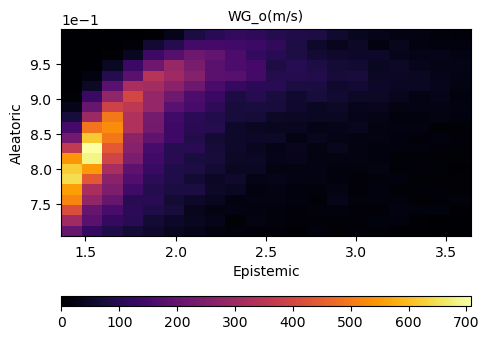

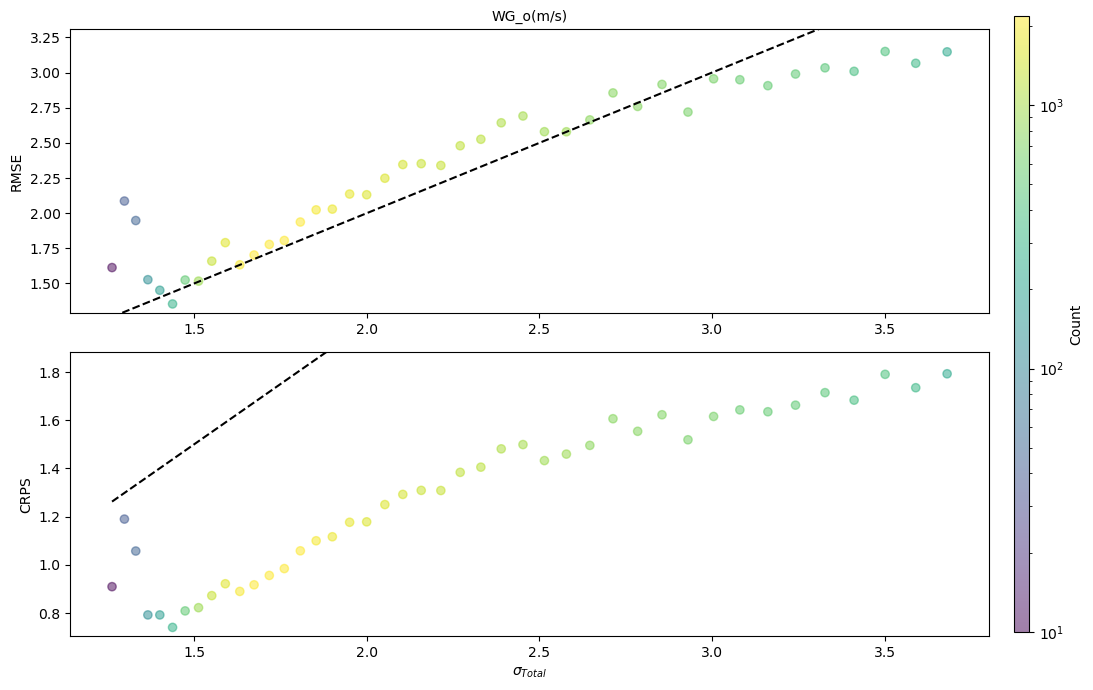

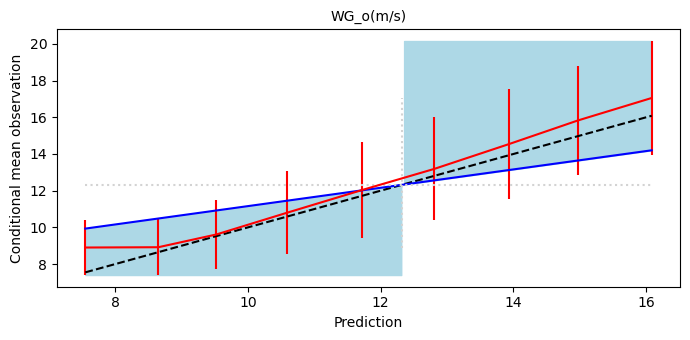

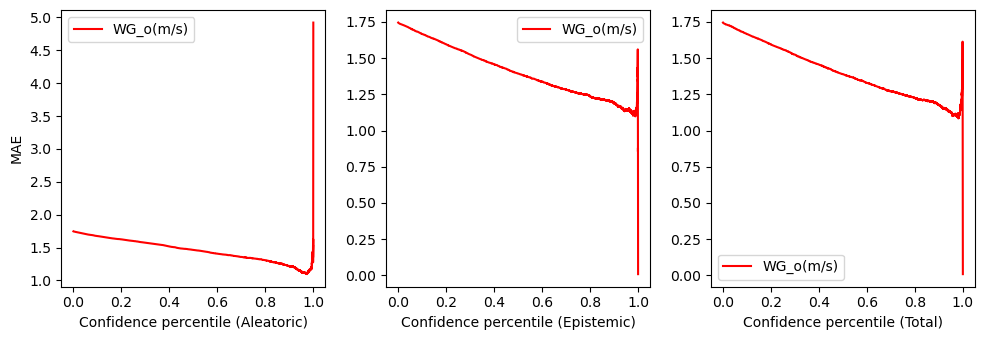

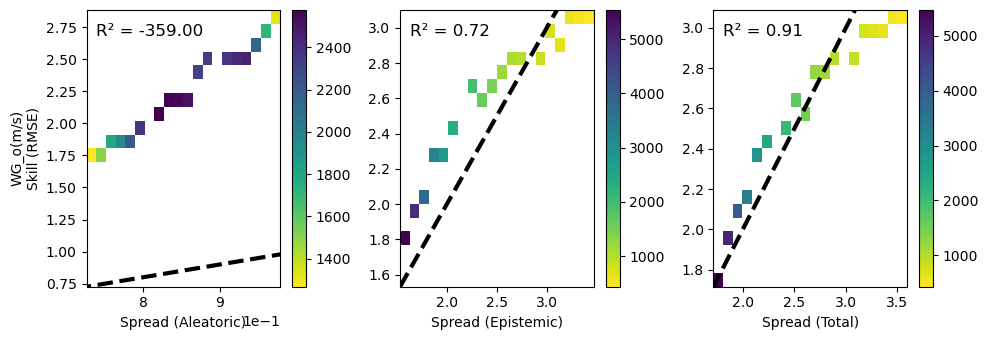

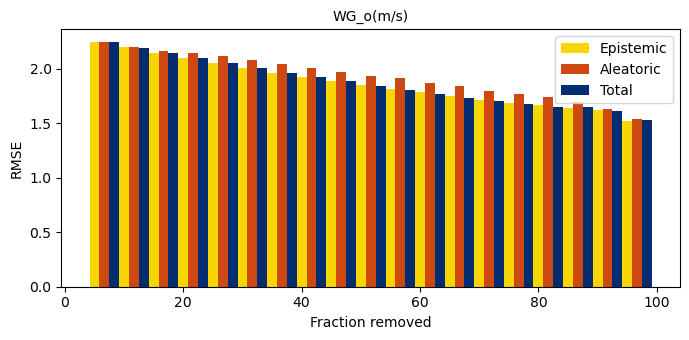

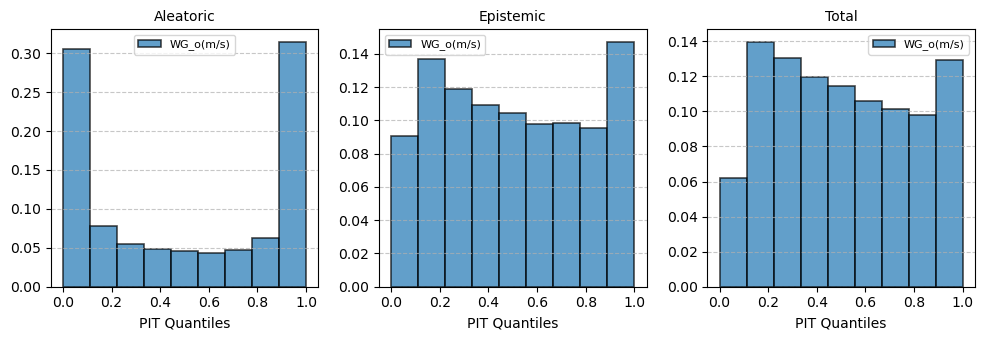

In [99]:
compute_results(
    empty_df,
    output_vars,
    mu,
    aleatoric,
    epistemic,
    legend_cols=output_vars,
    fn=os.path.join(save_loc)
)

In [93]:
final_interpolated_df_new.to_csv('Var_Interpolated_hourwise_all_test_storms.csv',index=False)

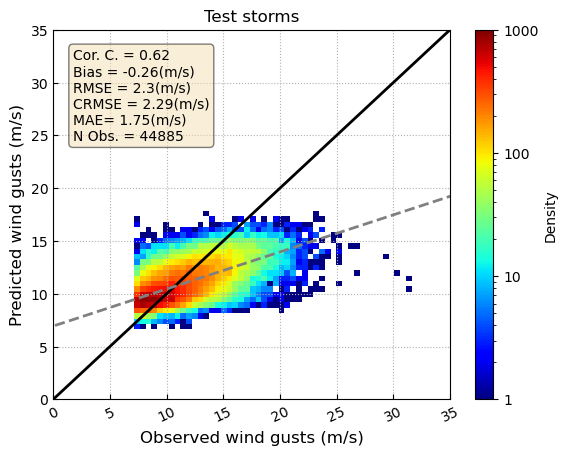

In [95]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import array as ar
from statistics import mean
from scipy import stats
import matplotlib as mpl
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle as pkl


Y_pred_all = empty_df['WG_o(m/s)_pred']
Y_test_all = empty_df['WG_o(m/s)']

Y_pred_all=np.array(Y_pred_all)
Y_test_all=np.array(Y_test_all)
Y_pred_all=Y_pred_all.ravel()
Y_test_all=Y_test_all.ravel()

#calculate error metrics for all Y_pred and Y_test data points together
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(Y_test_all,Y_pred_all)
MSE=round(MSE,2)
#print("MSE on test data:",MSE)
# Bias= Prediction-Observation
# This is mean bias
BIAS = np.mean(Y_pred_all-Y_test_all)
BIAS=round(BIAS,2)
#print("Bias on test data:",BIAS)
RMSE = mean_squared_error(Y_test_all,Y_pred_all)**0.5
RMSE=round(RMSE,2)
#print("RMSE on test data:",RMSE)
CRMSE = (RMSE**2-BIAS**2)**0.5
CRMSE=round(CRMSE,2)
#print("CRMSE on test data:",CRMSE)
MAE=mean_absolute_error(Y_test_all,Y_pred_all)
MAE=round(MAE,2)

slope, intercept, r_value, p_value, std_err = stats.linregress(Y_test_all,Y_pred_all)
r_value=round(r_value,2)
#Error_heading=['MSE','BIAS','RMSE','CRMSE','MAE','STD_obs','STD_pred','CV_obs','CV_pred','r_value']
Error_heading=['MSE','BIAS','RMSE','CRMSE','MAE','r_value']
#All_error=[MSE,BIAS,RMSE,CRMSE,MAE,STD_test,STD_pred,CV_test,CV_pred,r_value]
All_error=[MSE,BIAS,RMSE,CRMSE,MAE,r_value]
All_error = pd.DataFrame (All_error)
Error_heading = pd.DataFrame (Error_heading)
Error_df=pd.concat([Error_heading,All_error],axis=1)
Error_df.columns=['Error','Value']


fontszt   =12
titlesize =12
fontsz    =16
line_x = np.arange(-1000,10000,10)
c_min  = 1
c_max  = 1000
LWIDTH=2
trp    = 0.6
RTT    = 25.

def Heat_bin_plots(MINXY,MAXXY,INCR,Y_pred_all,Y_test_all,c_min,c_max,
                   xlabel_log,ylabel_log,title_log,yticks_log):
    fig, ax = plt.subplots(1)
    #bins    = (np.arange(MINXY,MAXXY+INCR,step=INCR),np.arange(MINXY,MAXXY+INCR,step=INCR))
    # I put the eps to hide the irreularity in the plot
    eps=0.01
    bins    = (np.arange(MINXY,MAXXY+INCR,step=INCR+eps),np.arange(MINXY,MAXXY+INCR,step=INCR+eps))
    img = plt.hist2d(Y_test_all, Y_pred_all,norm=mpl.colors.LogNorm(), bins=bins, cmin = 1,cmap=plt.cm.jet)
    cbar=plt.colorbar(label="Density", orientation="vertical")
    plt.clim(c_min,c_max)
    cbar.set_ticks([1,10, 100, 1000])
    cbar.set_ticklabels(["1","10", "100", "1000"])
    plt.plot(line_x, line_x,color='black',linewidth=LWIDTH)
    line_y = slope*line_x + intercept
    plt.plot(line_x, line_y,color='gray',linestyle='--',linewidth=LWIDTH)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05,0.95,"Cor. C. = "+str(round(r_value,2))+'\n' "Bias = "+str(BIAS)+'(m/s)'+'\n' "RMSE = "+str(RMSE)+'(m/s)'+'\n' "CRMSE = "+str(CRMSE)+'(m/s)'+'\n' "MAE= "+str(MAE)+'(m/s)'+
            '\n' "N Obs. = "+str(len(Y_test_all)),
            va='top', transform=ax.transAxes, fontsize = 10, color='black',bbox=props)
    # only keep the number of obs in the plot
    #ax.text(0.05,0.95,"Cor. C. = "+str(round(r_value,2))+'\n' "Number of obs. = "+str(len(Y_test_all)), va='top', transform=ax.transAxes, fontsize = 10, color='black')
    
    if title_log==1:
        #FIXME title 
        ax.set_title("Test storms",fontsize = titlesize)
    if xlabel_log==1:
        ax.set_xlabel("Observed wind gusts (m/s)", fontsize = titlesize)
    if ylabel_log==1:
        ax.set_ylabel("Predicted wind gusts (m/s)",fontsize = titlesize )
    if yticks_log==0:
        ax.set_yticklabels([])
    plt.xticks(rotation=RTT)
    ax.tick_params(axis='both',direction='in')
    plt.grid(visible=None, which='major', axis='both',linestyle=':')
    ax.set_xlim([MINXY,MAXXY])
    ax.set_ylim([MINXY,MAXXY]) 
    
Heat_bin_plots(0,35,0.5,Y_pred_all,Y_test_all,c_min,c_max,1,1,1,1)
plt.savefig('All_test_storms_interp_preds_vs_obs.png',dpi=300,bbox_inches='tight')